In [5]:
import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [6]:
# Column Mapping & Data Loading

census_svi_column_mapping = {
    'B01001_001E': 'Total Population',
    'B19001_001E': 'Household Income Distribution',
    'B19013_001E': 'Median Household Income',
    'B19001_002E': 'Income Bracket 1',
    'B19001_003E': 'Income Bracket 2',
    'B19001_004E': 'Income Bracket 3',
    'B19001_005E': 'Income Bracket 4',
    'B19001_006E': 'Income Bracket 5',
    'B19001_007E': 'Income Bracket 6',
    'B19001_008E': 'Income Bracket 7',
    'B19001_009E': 'Income Bracket 8',
    'B19001_010E': 'Income Bracket 9',
    'B19001_011E': 'Income Bracket 10',
    'B19001_012E': 'Income Bracket 11',
    'B19001_013E': 'Income Bracket 12',
    'B19001_014E': 'Income Bracket 13',
    'B19001_015E': 'Income Bracket 14',
    'B19001_016E': 'Income Bracket 15',
    'B19001_017E': 'Income Bracket 16',
    'state': 'State',
    'county': 'County',
    'tract': 'Census Tract',
    'year': 'Year',
    'STATE_COUNTY_FIPS': 'State-County FIPS Code',
    'GEOID': 'Geographic Identifier',
    'FIPS': 'FIPS Code',
    'RPL_THEMES': 'SVI Themes',
    'CZ_FIPS': 'Combined Statistical Area FIPS',
    'ST': 'State Abbreviation',
    'LOCATION': 'Location',
    'E_TOTPOP': 'Estimated Total Population',
    'M_TOTPOP': 'Margin of Error Total Population',
    'E_HU': 'Estimated Housing Units',
    'M_HU': 'Margin of Error Housing Units',
    'E_UNEMP': 'Estimated Unemployed',
    'M_UNEMP': 'Margin of Error Unemployed',
    'E_LIMENG': 'Estimated Limited English Proficiency',
    'M_LIMENG': 'Margin of Error Limited English Proficiency',
    'E_MUNIT': 'Estimated Multi-Unit Housing',
    'M_MUNIT': 'Margin of Error Multi-Unit Housing',
    'E_MOBILE': 'Estimated Mobile Homes',
    'M_MOBILE': 'Margin of Error Mobile Homes',
    'E_CROWD': 'Estimated Crowded Housing',
    'M_CROWD': 'Margin of Error Crowded Housing',
    'E_NOVEH': 'Estimated No Vehicle',
    'M_NOVEH': 'Margin of Error No Vehicle',
    'DAMAGE_PROPERTY': 'Damage to Property',
    'DAMAGE_CROPS': 'Damage to Crops',
    'BEGIN_YEARMONTH': 'Begin Year-Month',
    'LAT': 'Latitude',
    'LON': 'Longitude',
    'storm_county': 'Storm County'
}
def load_hurricane_data():
    dfs = []
    for year in range(2010, 2023):
        path = f'../data/df_clean/df_hurricane_{year}.csv'
        try:
            df = pd.read_csv(path)
            df = df.rename(columns=census_svi_column_mapping)
            df['Year'] = year
            dfs.append(df)
        except FileNotFoundError:
            print(f"Skipping {year}: file not found")
    full = pd.concat(dfs, ignore_index=True)
    print(f"Loaded full_data with shape: {full.shape}")
    return full

In [7]:
# Adding Features
def add_features(df):
    # vulnerability ratios
    df['pct_unemp']    = df['Estimated Unemployed']   / df['Total Population']
    df['pct_limm']     = df['Estimated Limited English Proficiency'] / df['Total Population']
    df['pct_noveh']    = df['Estimated No Vehicle']   / df['Total Population']
    # housing vulnerability
    df['pct_mobile']   = df['Estimated Mobile Homes'] / df['Estimated Housing Units']
    df['pct_crowd']    = df['Estimated Crowded Housing'] / df['Estimated Housing Units']
    # income‐distribution summaries
    lows  = [f'Income Bracket {i}' for i in (1,2,3)]
    highs = [f'Income Bracket {i}' for i in (14,15,16)]
    df['low_inc_pct']  = df[lows].sum(axis=1) / df['Household Income Distribution']
    df['high_inc_pct'] = df[highs].sum(axis=1) / df['Household Income Distribution']
    df['inc_ineq']     = df['high_inc_pct'] / (df['low_inc_pct'] + 1e-6)
    # log‐transforms
    df['log_pop']      = np.log1p(df['Total Population'])
    df['log_medinc']   = np.log1p(df['Median Household Income'])
    # seasonality
    df['Begin Year-Month'] = pd.to_datetime(df['Begin Year-Month'], format='%Y%m')
    df['month']         = df['Begin Year-Month'].dt.month
    # interaction
    df['pop_poverty']   = df['Total Population'] * df['low_inc_pct']
    return df


In [8]:
# Load & prepare data
full = load_hurricane_data()
full = add_engineered_features(full)

features = [
    'log_pop', 'log_medinc',
    'pct_unemp', 'pct_limm', 'pct_noveh',
    'low_inc_pct', 'pop_poverty',
    'month'
]

# split into training (2010-2021), testing (2022)
train_full = full[full['Year'] < 2022].reset_index(drop=True)
test_full  = full[full['Year'] == 2022].reset_index(drop=True)


# Spatial clustering & hold-out
coords = train_full[['Latitude', 'Longitude']].values
kmeans = KMeans(n_clusters=10, random_state=0).fit(coords)
train_full['spatial_cluster'] = kmeans.labels_

# hold-out cluster = 0
holdout_cluster = 0
train_df = train_full[train_full['spatial_cluster'] != holdout_cluster]
cv_df    = train_full[train_full['spatial_cluster'] == holdout_cluster]

print(f"Training counties: {train_df.shape[0]}, Spatial CV hold-out: {cv_df.shape[0]}")


Loaded full_data with shape: (185925, 52)
Training counties: 122452, Spatial CV hold-out: 42459


In [9]:
# Prepare X/y
def prepare_Xy(df):
    df = df.dropna(subset=features + ['Damage to Property'])
    X = df[features].values
    y = np.log1p(df['Damage to Property'].values)
    return X, y

X_train, y_train = prepare_Xy(train_df)
X_cv,    y_cv    = prepare_Xy(cv_df)
X_test,  y_test  = prepare_Xy(test_full)

# Scale & tensors
scaler = StandardScaler().fit(X_train)
X_train_t = torch.tensor(scaler.transform(X_train), dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_cv_t    = torch.tensor(scaler.transform(X_cv),    dtype=torch.float32)
y_cv_t    = torch.tensor(y_cv,    dtype=torch.float32)
X_test_t  = torch.tensor(scaler.transform(X_test),  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

# Pyro homoscedastic linear model
def model(X, y=None):
    n = X.shape[1]
    intercept = pyro.sample("intercept", dist.Normal(0., 10.))
    weights   = pyro.sample("weights",
                 dist.Normal(torch.zeros(n), 10*torch.ones(n)).to_event(1))
    sigma     = pyro.sample("sigma", dist.HalfNormal(10.))
    mu = intercept + (X * weights).sum(-1)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=y)

def guide(X, y=None):
    n = X.shape[1]
    pyro.sample("intercept",
        dist.Normal(pyro.param("intercept_loc", torch.tensor(0.)),
                    pyro.param("intercept_scale", torch.tensor(1.),
                                constraint=dist.constraints.positive)))
    pyro.sample("weights",
        dist.Normal(pyro.param("weights_loc", torch.zeros(n)),
                    pyro.param("weights_scale", torch.ones(n),
                                constraint=dist.constraints.positive))
        .to_event(1))
    pyro.sample("sigma",
        dist.HalfNormal(pyro.param("sigma_loc", torch.tensor(1.),
                                   constraint=dist.constraints.positive)))


Epoch 100: train_loss=1026992.3, cv_loss=792352.8
Epoch 200: train_loss=6039438.6, cv_loss=214656.3
Epoch 300: train_loss=2312294.5, cv_loss=11240460.8
Epoch 400: train_loss=7882756.4, cv_loss=1477465.5
Epoch 500: train_loss=2401477.3, cv_loss=4081337.4


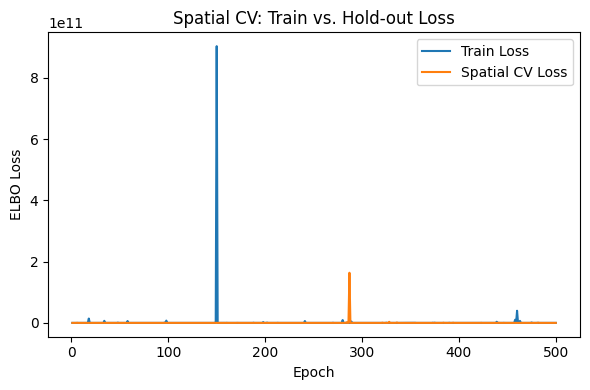

2022 Test MAE: 181800668.41, RMSE: 986288940.08


In [10]:
# Train with spatial CV
pyro.clear_param_store()
svi = SVI(model, guide, Adam({"lr":0.01}), loss=Trace_ELBO())

n_epochs = 500
train_losses, cv_losses = [], []
for ep in range(1, n_epochs+1):
    tl = svi.step(X_train_t, y_train_t)
    vl = svi.evaluate_loss(X_cv_t, y_cv_t)
    train_losses.append(tl)
    cv_losses.append(vl)
    if ep % 100 == 0:
        print(f"Epoch {ep}: train_loss={tl:.1f}, cv_loss={vl:.1f}")

# Plot spatial CV loss
plt.figure(figsize=(6,4))
epochs = range(1, n_epochs+1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, cv_losses,    label="Spatial CV Loss")
plt.xlabel("Epoch"); plt.ylabel("ELBO Loss")
plt.title("Spatial CV: Train vs. Hold-out Loss")
plt.legend(); plt.tight_layout(); plt.show()

# Final test evaluation on 2022
# Predict with guide means
b0 = pyro.param("intercept_loc").item()
w  = pyro.param("weights_loc").detach().numpy()
y_pred_test = np.expm1(b0 + X_test_t.numpy() @ w)
y_true_test = np.expm1(y_test)

mae  = mean_absolute_error(y_true_test, y_pred_test)
rmse = np.sqrt(((y_true_test - y_pred_test)**2).mean())
print(f"2022 Test MAE: {mae:.2f}, RMSE: {rmse:.2f}")

